In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [144]:
df = pd.read_csv('Solar.csv')
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

Dataset shape: (8760, 8)

First 5 rows:


,Date-Hour(NMT),WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,01.01.2017-00:00,0.6,0,1003.8,-7.4,0.1,97,0.0
1,01.01.2017-01:00,1.7,0,1003.5,-7.4,-0.2,98,0.0
2,01.01.2017-02:00,0.6,0,1003.4,-6.7,-1.2,99,0.0
3,01.01.2017-03:00,2.4,0,1003.3,-7.2,-1.3,99,0.0
4,01.01.2017-04:00,4.0,0,1003.1,-6.3,3.6,67,0.0


In [145]:
df.drop_duplicates(inplace=True)

In [146]:
df['Date-Hour(NMT)'] = pd.to_datetime(df['Date-Hour(NMT)'], format='%d.%m.%Y-%H:%M')

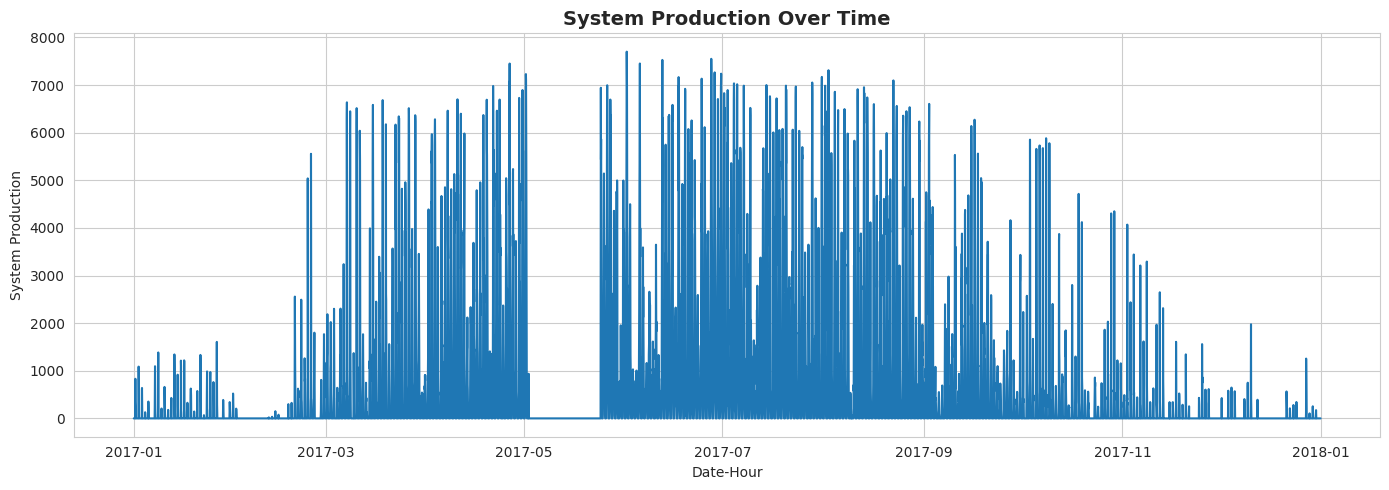

In [147]:
plt.figure(figsize=(14, 5))
sns.lineplot(x='Date-Hour(NMT)', y='SystemProduction', data=df)
plt.title('System Production Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date-Hour')
plt.ylabel('System Production')
plt.tight_layout()
plt.show()

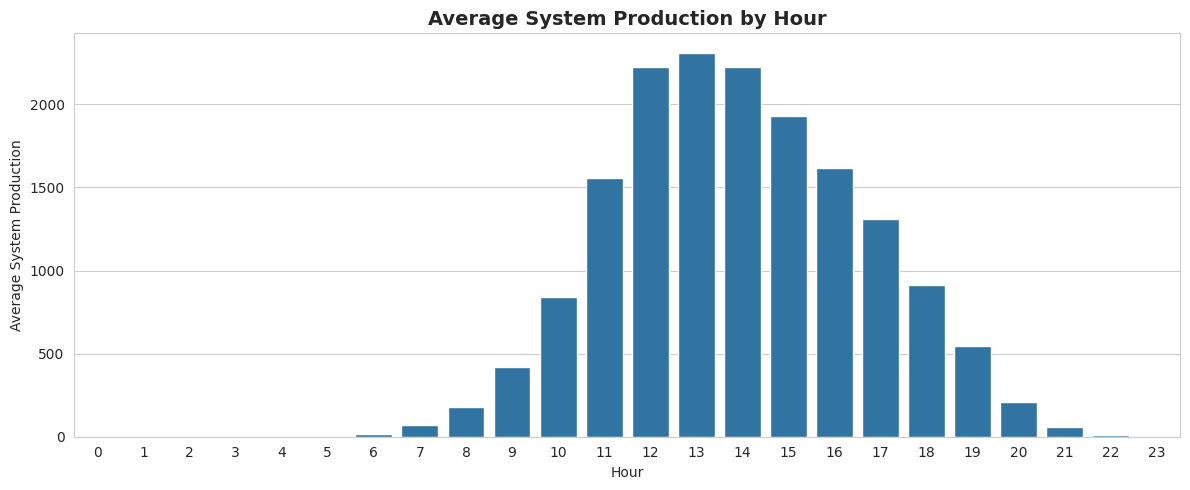

In [148]:
df['hour'] = df['Date-Hour(NMT)'].dt.hour
avg_production_by_hour = df.groupby('hour')['SystemProduction'].mean().reset_index()
plt.figure(figsize=(12, 5))
sns.barplot(x='hour', y='SystemProduction', data=avg_production_by_hour)
plt.title('Average System Production by Hour', fontsize=14, fontweight='bold')
plt.xlabel('Hour')
plt.ylabel('Average System Production')
plt.tight_layout()
plt.show()

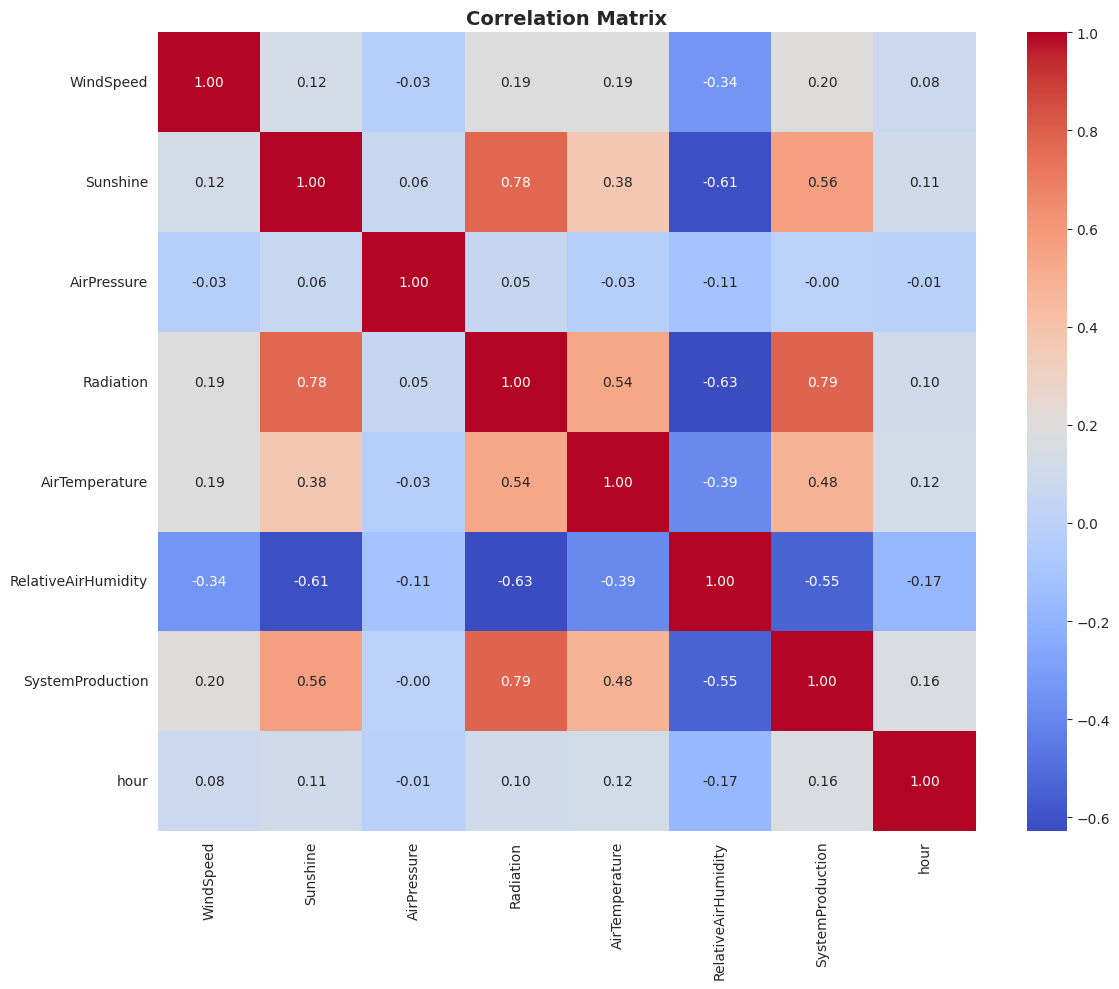

In [149]:
numerical_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


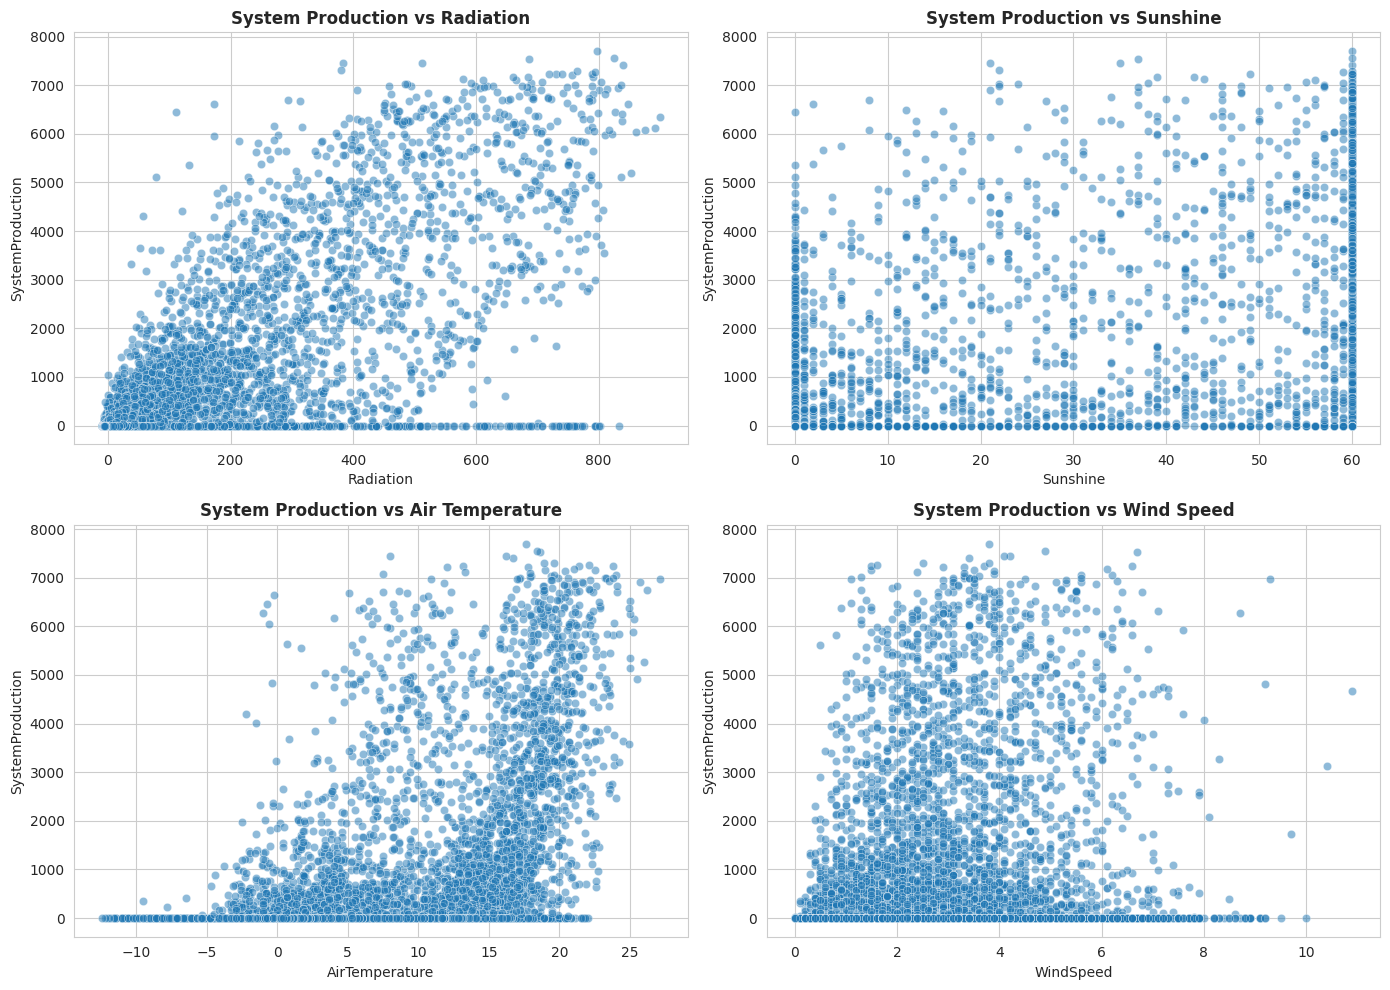

In [150]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(ax=axes[0, 0], x='Radiation', y='SystemProduction', data=df, alpha=0.5)
axes[0, 0].set_title('System Production vs Radiation', fontweight='bold')
sns.scatterplot(ax=axes[0, 1], x='Sunshine', y='SystemProduction', data=df, alpha=0.5)
axes[0, 1].set_title('System Production vs Sunshine', fontweight='bold')
sns.scatterplot(ax=axes[1, 0], x='AirTemperature', y='SystemProduction', data=df, alpha=0.5)
axes[1, 0].set_title('System Production vs Air Temperature', fontweight='bold')
sns.scatterplot(ax=axes[1, 1], x='WindSpeed', y='SystemProduction', data=df, alpha=0.5)
axes[1, 1].set_title('System Production vs Wind Speed', fontweight='bold')
plt.tight_layout()
plt.show()

In [151]:
df = pd.read_csv('Solar.csv')
df['Date-Hour(NMT)'] = pd.to_datetime(df['Date-Hour(NMT)'], format='%d.%m.%Y-%H:%M')

In [152]:
df['hour'] = df['Date-Hour(NMT)'].dt.hour
df['day'] = df['Date-Hour(NMT)'].dt.day
df['month'] = df['Date-Hour(NMT)'].dt.month
df['day_of_year'] = df['Date-Hour(NMT)'].dt.dayofyear
df['season'] = (df['month'] % 12 + 3) // 3 - 1
df['is_weekend'] = (df['Date-Hour(NMT)'].dt.dayofweek >= 5).astype(int)

In [153]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [154]:

for lag in [1, 2, 3, 6, 12, 24, 48, 72, 168]:
    df['Radiation_lag_{}h'.format(lag)] = df['Radiation'].shift(lag)
    df['SystemProduction_lag_{}h'.format(lag)] = df['SystemProduction'].shift(lag)

In [155]:

for window in [3, 6, 12, 24, 48]:
    df['Radiation_roll_mean_{}h'.format(window)] = df['Radiation'].rolling(window).mean()
    df['Radiation_roll_max_{}h'.format(window)] = df['Radiation'].rolling(window).max()
    df['Radiation_roll_min_{}h'.format(window)] = df['Radiation'].rolling(window).min()

In [156]:

df['Radiation_x_Sunshine'] = df['Radiation'] * df['Sunshine']
df['Radiation_x_Temperature'] = df['Radiation'] * df['AirTemperature']

In [157]:
df.dropna(inplace=True)
print("Features created:", df.shape[1] - 2)

Features created: 51


In [158]:
X = df.drop(['SystemProduction', 'Date-Hour(NMT)'], axis=1)
y = df['SystemProduction']

In [159]:
split_index = int(len(df) * 0.8)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]


In [160]:
print("Training samples:", len(X_train))
print("Test samples:", len(X_test))
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Training samples: 6873
Test samples: 1719


In [161]:
tscv = TimeSeriesSplit(n_splits=3)

In [162]:
lgb_params = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50],
    'subsample': [0.8, 1.0]
}

In [163]:
lgb_search = RandomizedSearchCV(
    lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    lgb_params, n_iter=20, cv=tscv, scoring='r2', n_jobs=-1, random_state=42, verbose=0
)
lgb_search.fit(X_train_scaled, y_train)
best_lgb = lgb_search.best_estimator_
print("Best LightGBM CV R2:", round(lgb_search.best_score_, 4))


Best LightGBM CV R2: 0.7229


In [164]:
print("\nTuning XGBoost...")
xgb_params = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1),
    xgb_params, n_iter=20, cv=tscv, scoring='r2', n_jobs=-1, random_state=42, verbose=0
)
xgb_search.fit(X_train_scaled, y_train)
best_xgb = xgb_search.best_estimator_
print("Best XGBoost CV R2:", round(xgb_search.best_score_, 4))


Tuning XGBoost...
Best XGBoost CV R2: 0.7599


In [165]:
rf_model = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=15, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [166]:
print("\nTraining Voting Regressor...")
voting_model = VotingRegressor([
    ('lgb', best_lgb),
    ('xgb', best_xgb),
    ('rf', rf_model)
], weights=[2, 2, 1])
voting_model.fit(X_train_scaled, y_train)


Training Voting Regressor...


VotingRegressor(estimators=[('lgb',
                             LGBMRegressor(max_depth=7, n_estimators=200,
                                           n_jobs=-1, random_state=42,
                                           verbose=-1)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          fe...
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=200,
                                          n_jobs=-1, num_parallel_tree=None, ...)),
                            ('rf',
                             RandomForestRegressor(max_depth=15,
                                                   n_estimators=300, n_jobs=-1,
                                                   random_state=42))],
                weights=[2, 2, 1])

In [167]:
models = {
    'LightGBM': best_lgb,
    'XGBoost': best_xgb,
    'Random Forest': rf_model,
    'Voting Ensemble': voting_model
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append({'Model': name, 'R2': r2, 'RMSE': rmse, 'MAE': mae})

results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print("\nModel Performance:")
display(results_df)


Model Performance:


,Model,R2,RMSE,MAE
0,LightGBM,0.528638,214.626750,53.773446
3,Voting Ensemble,0.462379,229.216004,58.417680
2,Random Forest,0.397596,242.633407,62.180894
1,XGBoost,0.379502,246.250443,64.847004


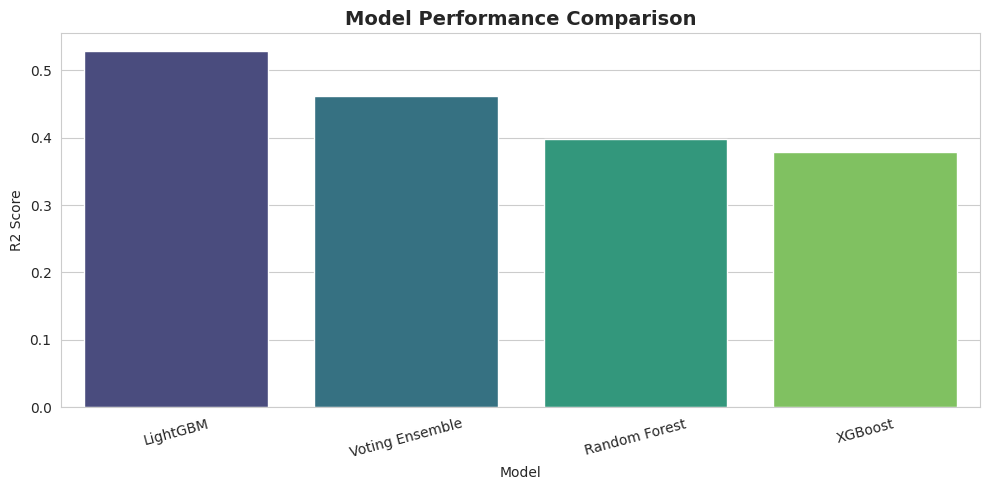

In [168]:
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='R2', palette='viridis')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('R2 Score')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [169]:
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_r2 = results_df.iloc[0]['R2']

print("\nBest Model:", best_model_name)
print("R2 Score:", round(best_r2, 4))
print("RMSE:", round(results_df.iloc[0]['RMSE'], 4))
print("MAE:", round(results_df.iloc[0]['MAE'], 4))

y_pred_best = best_model.predict(X_test_scaled)


Best Model: LightGBM
R2 Score: 0.5286
RMSE: 214.6267
MAE: 53.7734


Text(0.5, 1.0, 'Actual vs Predicted')

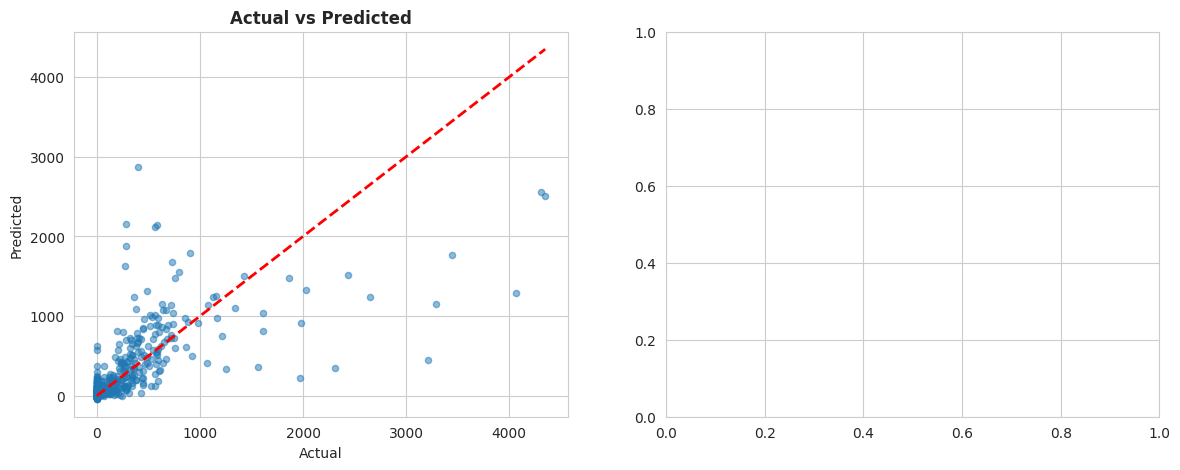

In [170]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(y_test, y_pred_best, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Actual vs Predicted', fontweight='bold')

In [171]:
residuals = y_test - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot', fontweight='bold')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>


Top 20 Important Features:


,Feature,Importance
17,SystemProduction_lag_1h,301
16,Radiation_lag_1h,217
27,SystemProduction_lag_24h,169
32,Radiation_lag_168h,156
29,SystemProduction_lag_48h,151
31,SystemProduction_lag_72h,149
33,SystemProduction_lag_168h,149
19,SystemProduction_lag_2h,147
2,AirPressure,147
30,Radiation_lag_72h,143


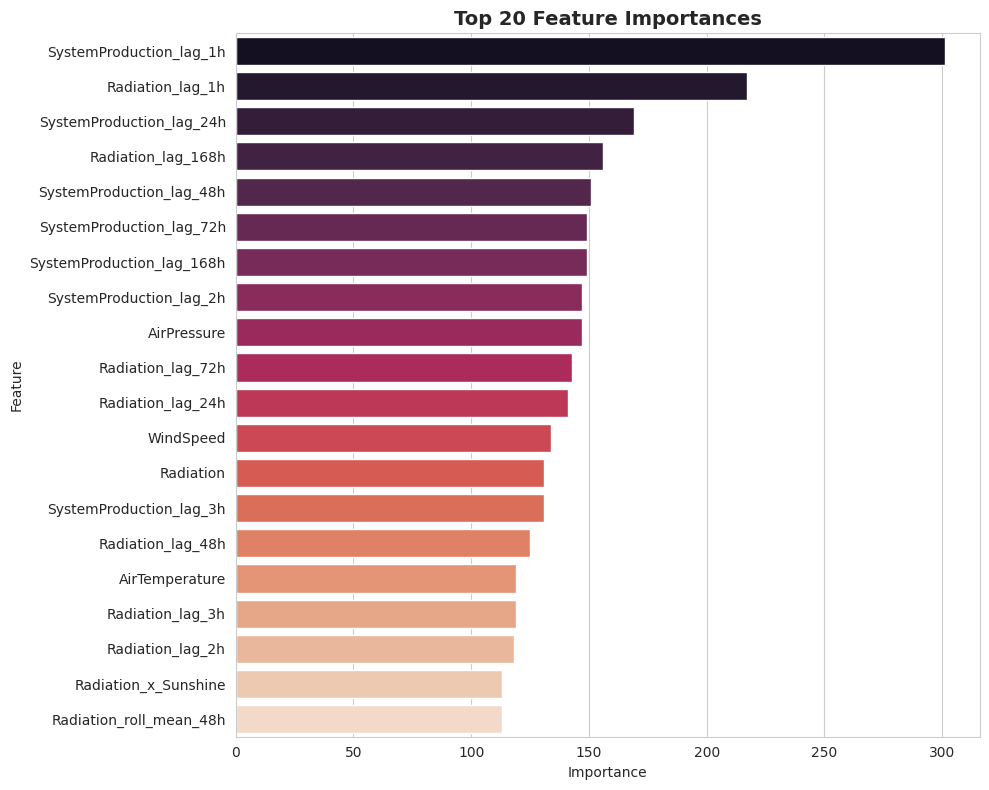

In [172]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X_train.columns.tolist()

    feature_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(20)

    print("\nTop 20 Important Features:")
    display(feature_df)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_df, y='Feature', x='Importance', palette='rocket')
    plt.title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [177]:
print("\nSECTION 8: SAVING MODEL")
print("-" * 80)

with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Model saved: best_model.pkl")

results_df.to_csv('model_results.csv', index=False)
print("Results saved: model_results.csv")


SECTION 8: SAVING MODEL
--------------------------------------------------------------------------------
Model saved: best_model.pkl
Results saved: model_results.csv


In [174]:
print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print("\nBest Model:", best_model_name)
print("Final R2 Score:", round(best_r2, 4))
print("\nSaved Files:")
print("- best_model.pkl")
print("- scaler.pkl")
print("- model_results.csv")
print("=" * 80)


ANALYSIS COMPLETE

Best Model: LightGBM
Final R2 Score: 0.5286

Saved Files:
- best_model.pkl
- scaler.pkl
- model_results.csv
